<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab9.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms


### Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. Your agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training. The below graphs show example results for dqn (left) and ppo (right).

## Init

In [1]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
####################
! pip install pyvirtualdisplay
! apt-get install -y xvfb python-opengl ffmpeg
####################

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-do

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

####################
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
####################

In [3]:
######################
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()
######################

In [4]:
######################
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video')
  return env
######################

## DQN

## Part 1


Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

## I get bored out of my mind doing these projects so to keep myself entertained I make crazy varaible names. I still understand what's going on. Sorry if it confuses you. I can change it if you want. 

In [7]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
    """
    Select an action according to an e-greedy policy and decay epsilon.

    Args:
        network (QNetwork): the Q-network used to select actions
        state (np-array): the current state
        epsilon (float): the probability of choosing a random action
        epsilon_decay (float): the decay factor for epsilon

    Returns:
        action (int): the action chosen by the agent
        epsilon (float): the decayed epsilon value
    """

    #decay the epsilon value
    decay = epsilon * epsilon_decay

    #if a random number is less than epsilon, choose a random action
    if np.random.rand() < epsilon:
        return np.random.randint(2), decay

    #otherwise, use the Q-network to select the best action
    #we are assuming that the Q-network is already on the GPU
    action = network(torch.tensor(state, dtype=torch.float).cuda())
    best_action = torch.argmax(action).item()

    return best_action, decay



def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  #initialize empty lists 
  state = []
  action = []
  next_state = []
  reward = []
  done = []

  #randomly sample batch_size number of state, action, next_state, reward and done tuples from memory
  for s, a, n, r, d in random.sample(memory, batch_size):
      state.append(s)
      action.append(a)
      next_state.append(n)
      reward.append(r)
      done.append(d)

  #convert the lists to torch tensors and move them to GPU memory
  state = torch.tensor(state).cuda()
  action = torch.tensor(action).cuda()
  next_state = torch.tensor(next_state).cuda()
  reward = torch.tensor(reward).cuda()
  done = torch.tensor(done).cuda()

  #return the batch of tensors
  return state, action, next_state, reward, done



  
def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """

  #zero the gradients
  optim.zero_grad()

  state, action, next_state, reward, done = batch
  temp = q_network(state.float())

  #select the Q-value corresponding to the chosen action for each sample in the batch
  learn_1 = torch.gather(temp, 1, action.view(-1,1)).squeeze()
  #compute the target Q-values for each sample in the batch using the Target Q-Network and the Bellman equation
  learn_2 = reward + gamma * torch.max(target_network(next_state.float()).cuda(), dim=1).values * (1 - done.int())

  #compute the cumulative loss for the batch as the mean squared error between the predicted Q-values and the target Q-values
  cum_loss = torch.sum(((learn_1 - (learn_2))**2))
  cum_loss.backward()

  #update the Q-Network parameters
  optim.step()

  #update the Target Q-Network with the parameters of the Q-Network 
  if global_step % target_update == 0:
      target_network.load_state_dict(q_network.state_dict())


### Modules

In [8]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))  
    
  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [9]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 500
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    ######################
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)
    ######################

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < 200:  # End after 200 steps 
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)
        
        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    ######################
    env.close()
    ######################
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))
  
  return results_dqn

results_dqn = dqn_main()
######################
show_video()
######################

Episodes: 47 Reward: 15.0:  10%|▉         | 48/500 [00:02<00:27, 16.47it/s]<ipython-input-7-880d5ca38e77>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.tensor(state).cuda()
Episodes: 498 Reward: 177.0: 100%|█████████▉| 499/500 [01:04<00:00,  2.89it/s]

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4




t:  91%|█████████ | 183/202 [00:00<00:00, 253.51it/s, now=None]
                                                                              

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


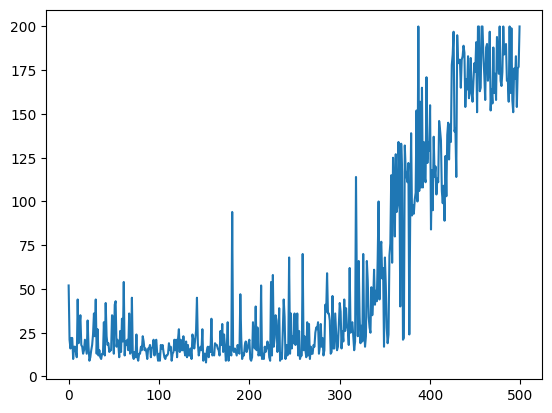

In [10]:
plt.plot(results_dqn)
plt.show()

## PPO

## Part 2

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$. 

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-1}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory. 

Additionally, the $clip$ function clips the value of the first argument according to the lower and upper bounds in the second and third arguments resectively.

Another important note: Your the calculation of your advantage $\hat{A}$ should not permit gradient flow from your policy loss calculation. In other words, make sure to call `.detach()` on your advantage.

In [23]:
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """
  #initialize
  r_e_t_u_r_n = 0       
  memory_list = []          

  #iterate over the rollout list in reverse order
  for state, action, action_dist, reward in reversed(rollout):
      r_e_t_u_r_n = reward + r_e_t_u_r_n * gamma  #calculate discounted return for this time step
      memory_list.append((state, action, action_dist, r_e_t_u_r_n))  #add updated experience tuple to memory

  return memory_list   



def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  #no gradient to be computed during the forward pass
  with torch.no_grad():

    #convert the state into a torch tensor 
    state_tensor = torch.cuda.FloatTensor(state).unsqueeze(0)
    bananas = network(state_tensor)

    #detach the output from the computational graph
    oranges = bananas.detach().cpu().numpy()[0]

    #sample an action from the output distribution
    action = np.argmax(np.random.multinomial(1, oranges))

    # return the sampled action and the output distribution obtained from the policy network
    return action, bananas

def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
    """Implement PPO policy and value network updates. Iterate over your entire 
    memory the number of times indicated by policy_epochs.    

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
        value (ValueNetwork): Value Network
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
    """

    device = next(policy.parameters()).device
    """I get bored out of my mind doing these projects so to keep myself entertained I make crazy varaible names. 
    I understand it. Sorry if it confuses you. I can change it if you want."""

    for i in range(policy_epochs):
        for state, action, action_dist, r_e_t_u_r_n in memory_dataloader:
            optim.zero_grad()

            #move state tensor to GPU
            state = state.to(device)

            #calculate the probability of the action taken given the state
            back = action_dist.squeeze(1)[range(action_dist.shape[0]), action]

            #get the probability distribution of the policy network for the given state
            exSQUEEZEme = policy(state)
            current = exSQUEEZEme.squeeze(1)[range(exSQUEEZEme.shape[0]), action]

            #calculate the advantage of the action taken
            guessrrrr = r_e_t_u_r_n - value(state).squeeze(1)

            #calculate the policy loss
            sunrise = (current / back) * guessrrrr.detach()
            sunset = torch.clamp((current / back), 1 - epsilon, 1 + epsilon) * guessrrrr.detach()
            policy_loss = -torch.mean(torch.min(sunrise, sunset))

            #calculate the value loss
            loss = (guessrrrr**2).mean()

            #calculate the total loss as the sum of policy and value loss
            total_loss = policy_loss + loss

            #backpropagate the gradients through the network and update the optimizer
            policy_loss.backward()
            optim.step()


### Modules

In [24]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))
  
  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)
  

# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8
  
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))
    
  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

In [25]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment 
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    ######################
    last_epoch = (epoch+1 == epochs)
    # Record only last epoch
    if last_epoch:
      env = wrap_env(env)
    ######################
    
    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):
      
      # Reset environment
      state, _ = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps   
        # Get action
        action, action_dist = get_action_ppo(policy_network, state)
        
        # Take step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      ######################
      env.close()
      ######################
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)
    
    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()
######################
show_video()
######################

Epochs: 18 Reward: 28.0:  95%|█████████▌| 19/20 [00:17<00:00,  1.30it/s]

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4




t:  96%|█████████▌| 45/47 [00:00<00:00, 444.31it/s, now=None]


Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Moviepy - Building video /content/video/rl-video-episode-1.mp4.


Epochs: 18 Reward: 28.0:  95%|█████████▌| 19/20 [00:18<00:00,  1.30it/s]

Moviepy - Writing video /content/video/rl-video-episode-1.mp4




Epochs: 18 Reward: 28.0:  95%|█████████▌| 19/20 [00:18<00:00,  1.30it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4




Epochs: 18 Reward: 28.0:  95%|█████████▌| 19/20 [00:18<00:00,  1.30it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4




t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4


  0%|          | 0/20 [02:55<?, ?it/s]

Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4




Epochs: 18 Reward: 28.0:  95%|█████████▌| 19/20 [00:19<00:00,  1.30it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4


Moviepy - Building video /content/video/rl-video-episode-27.mp4.


  0%|          | 0/20 [02:55<?, ?it/s]

Moviepy - Writing video /content/video/rl-video-episode-27.mp4




  0%|          | 0/20 [02:55<?, ?it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4


  0%|          | 0/20 [02:56<?, ?it/s]

Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4




  0%|          | 0/20 [02:56<?, ?it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4


  0%|          | 0/20 [02:56<?, ?it/s]

Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4




  0%|          | 0/20 [02:56<?, ?it/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4


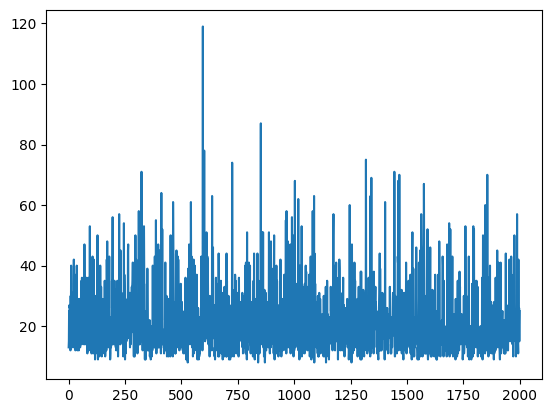

In [26]:
plt.plot(results_ppo)
plt.show()